In [273]:
!pip install yfinance
!pip install pandas_ta
import pandas as pd
import yfinance as yf
import pandas_ta as ta
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

import warnings
warnings.filterwarnings("ignore")

import pickle

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split

In [200]:
# Load silver price
df = yf.Ticker("SI=F")
data = df.history(period="max")
data.drop([column for column in data.columns if column not in ['Open','Close', 'High', 'Low']], axis=1, inplace=True)

In [201]:
data.head()

,Open,High,Low,Close
Date,,,,
2000-08-30,4.950,4.950,4.895,4.930
2000-08-31,4.920,5.045,4.920,5.003
2000-09-01,5.035,5.035,4.985,5.004
2000-09-05,4.990,5.005,4.975,4.998
2000-09-06,5.000,5.000,4.980,4.983


In [202]:
chart = yf.Ticker("SI=F").history(period="2y")
fig = go.Figure(data=[go.Candlestick(x=chart.index,
                open=chart['Open'],
                high=chart['High'],
                low=chart['Low'],
                close=chart['Close'])])

fig.show()

In [203]:
# Add gold price
df = yf.Ticker("GC=F")
gold = df.history(period="max")
data['Gold'] = gold['Close']

In [204]:
data.isna().sum()

Open     0
High     0
Low      0
Close    0
Gold     3
dtype: int64

In [205]:
data['Gold'].fillna(method='ffill', inplace=True)

In [206]:
data.isna().sum()

Open     0
High     0
Low      0
Close    0
Gold     0
dtype: int64

In [207]:
data.tail()

,Open,High,Low,Close,Gold
Date,,,,,
2022-04-21,25.280001,25.280001,24.621000,24.621000,1944.900024
2022-04-22,24.725000,24.725000,24.215000,24.257000,1931.000000
2022-04-25,23.667999,23.667999,23.667999,23.667999,1893.199951
2022-04-26,23.542000,23.594999,23.542000,23.542000,1901.400024
2022-04-27,23.590000,23.670000,23.535000,23.594999,1898.800049


In [208]:
# Add Silver and Gold price change 10, 30, 100 days in percentage points
windows = [10, 30, 100]
for window in windows:
    data["Silver_"+str(window)] = data['Close'].rolling(window+1).apply(lambda x: (x.iloc[window] - x.iloc[0]) / x.iloc[0] * 100)
    data["Gold_"+str(window)] = data['Gold'].rolling(window+1).apply(lambda x: (x.iloc[window] - x.iloc[0]) / x.iloc[0] * 100)

In [209]:
data.tail()

,Open,High,Low,Close,Gold,Silver_10,Gold_10,Silver_30,Gold_30,Silver_100,Gold_100
Date,,,,,,,,,,,
2022-04-21,25.280001,25.280001,24.621000,24.621000,1944.900024,0.678799,1.381359,-4.410450,-2.064555,6.552127,8.939672
2022-04-22,24.725000,24.725000,24.215000,24.257000,1931.000000,-1.924554,-0.144795,-7.423096,-3.358189,6.395018,8.343149
2022-04-25,23.667999,23.667999,23.667999,23.667999,1893.199951,-4.637580,-2.492791,-9.338855,-4.514047,3.966615,6.743346
2022-04-26,23.542000,23.594999,23.542000,23.542000,1901.400024,-5.749062,-2.206451,-6.742195,-2.969991,5.574241,6.724296
2022-04-27,23.590000,23.670000,23.535000,23.594999,1898.800049,-8.279887,-3.716846,-6.082076,-1.540055,5.902148,7.843477


In [210]:
# Add technical indicators RSI, MACD and Stochastic Oscillator for Silver
data['RSI_14']=ta.rsi(data['Close'],lenght=14)

MACD = ta.macd(data['Close'],fast=12, slow=26, signal=9)
data = pd.concat([data,MACD],axis=1)

STOCH = ta.stoch(high=data.High,low=data.Low,close=data.Close)
data = pd.concat([data, STOCH], axis=1)

In [211]:
data.tail()

,Open,High,Low,Close,Gold,Silver_10,Gold_10,Silver_30,Gold_30,Silver_100,Gold_100,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,STOCHk_14_3_3,STOCHd_14_3_3
Date,,,,,,,,,,,,,,,,,
2022-04-21,25.280001,25.280001,24.621000,24.621000,1944.900024,0.678799,1.381359,-4.410450,-2.064555,6.552127,8.939672,44.782169,0.104334,-0.026097,0.130431,41.888926,63.909431
2022-04-22,24.725000,24.725000,24.215000,24.257000,1931.000000,-1.924554,-0.144795,-7.423096,-3.358189,6.395018,8.343149,41.698991,0.017412,-0.090416,0.107827,23.153213,45.020230
2022-04-25,23.667999,23.667999,23.667999,23.667999,1893.199951,-4.637580,-2.492791,-9.338855,-4.514047,3.966615,6.743346,37.232059,-0.097874,-0.164561,0.066687,5.930978,23.657706
2022-04-26,23.542000,23.594999,23.542000,23.542000,1901.400024,-5.749062,-2.206451,-6.742195,-2.969991,5.574241,6.724296,36.335352,-0.197133,-0.211056,0.013923,0.727270,9.937154
2022-04-27,23.590000,23.670000,23.535000,23.594999,1898.800049,-8.279887,-3.716846,-6.082076,-1.540055,5.902148,7.843477,37.022432,-0.268426,-0.225879,-0.042547,0.767748,2.475332


In [212]:
# Prepare the target - Silver price direction change over next window days
window = 10
data['Target'] = data['Close'].rolling(window + 1).apply(lambda x: x.iloc[window] > x.iloc[0]) 

In [213]:
# We want to know the future outcome pre-fact to train our model
data['Target'] = data['Target'].shift(-window)

In [214]:
data.shape

(5435, 18)

In [215]:
data.isna().sum()

Open               0
High               0
Low                0
Close              0
Gold               0
Silver_10         10
Gold_10           10
Silver_30         30
Gold_30           30
Silver_100       100
Gold_100         100
RSI_14            14
MACD_12_26_9      25
MACDh_12_26_9     33
MACDs_12_26_9     33
STOCHk_14_3_3     15
STOCHd_14_3_3     17
Target            10
dtype: int64

In [216]:
# Remove first 100 rows (missing values for technical indicators) and last 10 rows (missing Target)
data.dropna(axis=0, inplace=True)
data.isna().sum().sum()

0

In [217]:
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Gold', 'Silver_10', 'Gold_10',
       'Silver_30', 'Gold_30', 'Silver_100', 'Gold_100', 'RSI_14',
       'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'STOCHk_14_3_3',
       'STOCHd_14_3_3', 'Target'],
      dtype='object')

In [218]:
# We can remove first 5 columns, as we are not interested in present nominal values
data.drop(['Open','High','Low','Close','Gold'], axis=1, inplace=True)

In [219]:
# Saving copy of clean data
data.to_csv('data.csv')

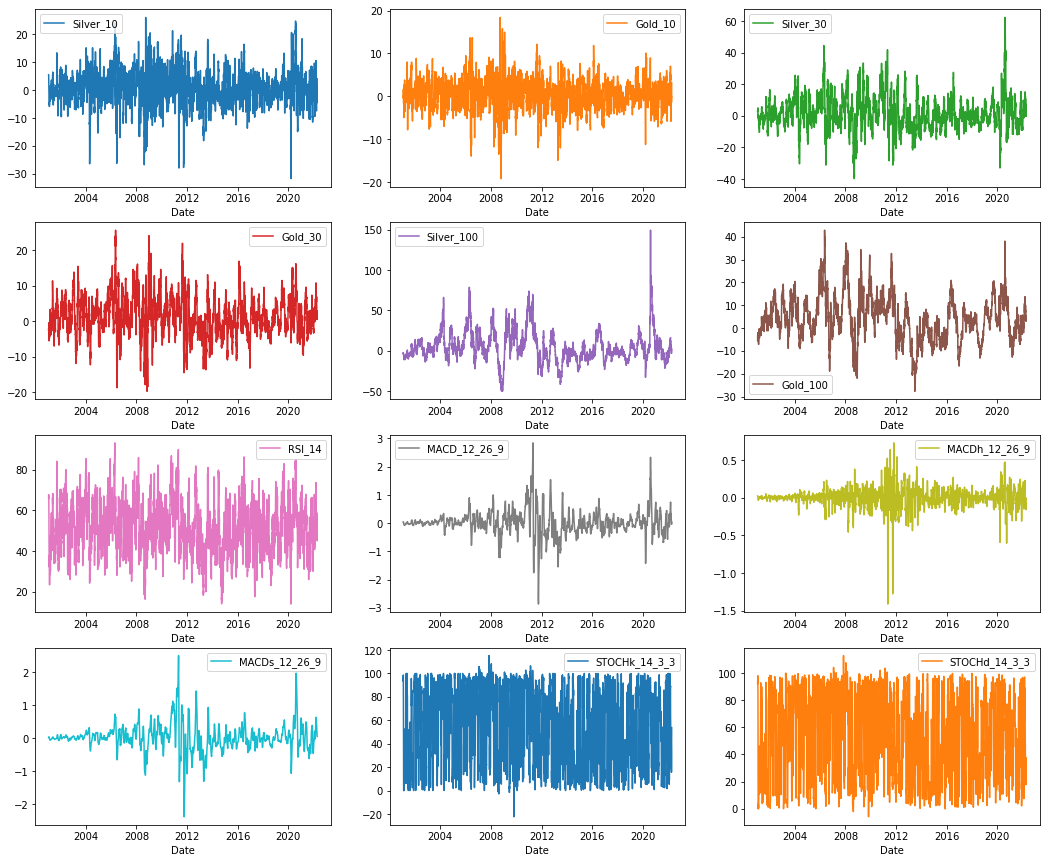

In [220]:
features = data[[column for column in data.columns if column !='Target']]
features.plot(subplots=True, sharex=False, layout=(4,3), figsize=(18,15))
plt.show()

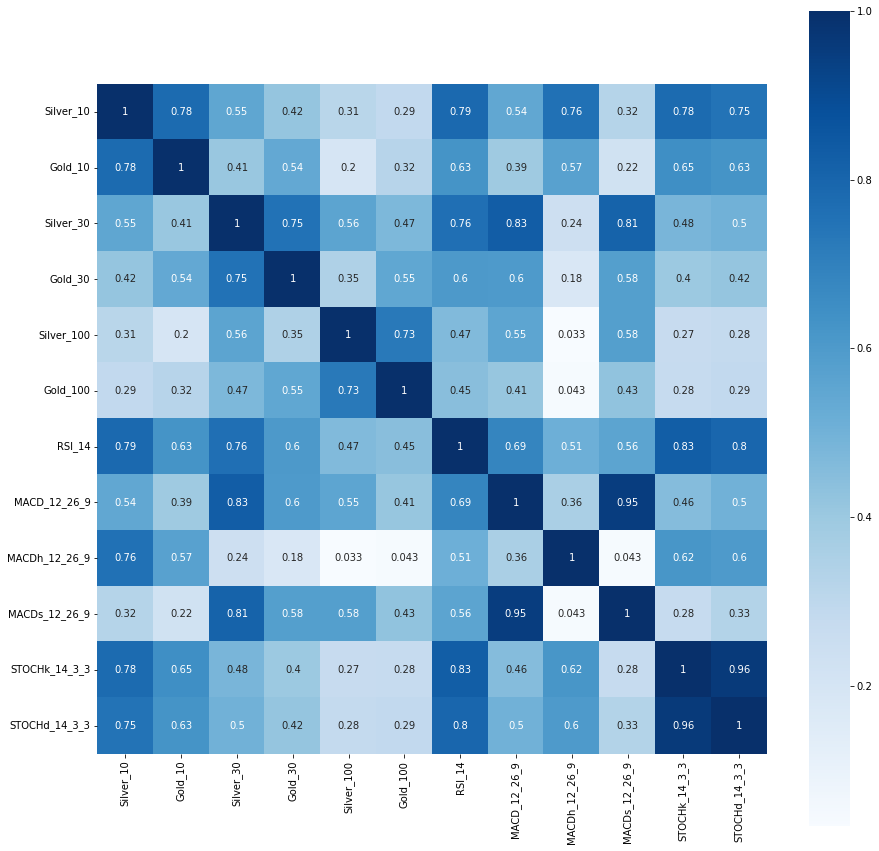

In [221]:
plt.figure(figsize=(15,15))
sns.heatmap(features.corr(),square=True,cmap="Blues",annot=True)
plt.show()

In [222]:
target = data['Target']

In [223]:
target.value_counts()

1.0    2872
0.0    2453
Name: Target, dtype: int64

In [224]:
target.value_counts(normalize=True)

1.0    0.539343
0.0    0.460657
Name: Target, dtype: float64

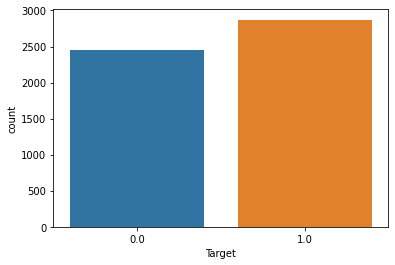

In [225]:
ax = sns.countplot(target)
plt.show()

54% of the ten-day periods were up for silver. 54% of the ten-day periods were up for silver. This means that a naive algorithm that always forecasts price increases would have 54% accuracy. We will try to beat this result.

For model selection, we will select the most promising models taking into account our previous projects and financial literature.


In [226]:
models = []
models.append(('RF', RandomForestClassifier()))
models.append(('ADA', AdaBoostClassifier()))
models.append(('GRAD', GradientBoostingClassifier()))

In [227]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=9)

In [ ]:
results = []
names = []
for name, model in models:
    results.append(cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy'))
    names.append(name)

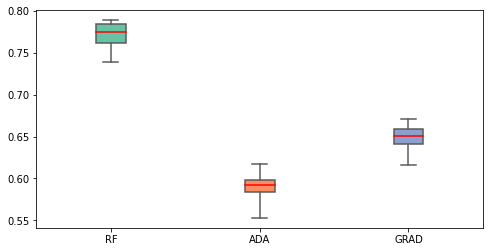

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))
sns.boxplot(ax=ax, data=results, orient='v',  palette="Set2", saturation=1, width=0.2, whis=5, medianprops=dict(color="red", alpha=1))
ax.set_xticklabels(names)
plt.show()

In [ ]:
n_estimators = range(10,150,10)
params = {
    'n_estimators': n_estimators,
    }

In [ ]:
grid = GridSearchCV(estimator=RandomForestClassifier(), param_grid=params, scoring='accuracy', cv=10)

In [ ]:
results = grid.fit(X_train, y_train)

In [ ]:
print(results.best_params_)
print(results.best_score_)

{'n_estimators': 110}
0.7715388014360673


0.708850 (0.016663) with: {'n_estimators': 10}
0.737259 (0.016327) with: {'n_estimators': 20}
0.748294 (0.011518) with: {'n_estimators': 30}
0.753929 (0.016919) with: {'n_estimators': 40}
0.760972 (0.019786) with: {'n_estimators': 50}
0.760272 (0.015728) with: {'n_estimators': 60}
0.758618 (0.020979) with: {'n_estimators': 70}
0.766607 (0.013583) with: {'n_estimators': 80}
0.760737 (0.012133) with: {'n_estimators': 90}
0.766376 (0.010840) with: {'n_estimators': 100}
0.771539 (0.011342) with: {'n_estimators': 110}
0.763553 (0.011833) with: {'n_estimators': 120}
0.770133 (0.013757) with: {'n_estimators': 130}
0.771070 (0.009068) with: {'n_estimators': 140}


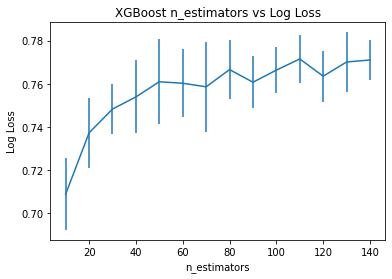

In [ ]:
means = results.cv_results_['mean_test_score']
stds = results.cv_results_['std_test_score']
params = results.cv_results_['params']
plt.errorbar(n_estimators, means, yerr=stds)
plt.title("Accuracy of Random Forest algoritm")
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

It seems that without changing other parameters, we achieve the highest accuracy of 0.77 with n_estimators = 110. Let's try to optimize the remaining parameters.

In [ ]:
params = {
     'n_estimators': [110],
     'bootstrap': [True, False],
     'max_features': ['auto', 'sqrt'],
     'min_samples_split' : [2, 4],
     'min_samples_leaf' : [1, 2],
     'criterion' : ["gini","entropy"]
     }

In [ ]:
grid = GridSearchCV(estimator=RandomForestClassifier(), param_grid=params, scoring='accuracy', cv=10)
# Computing time ~ 16 mins
results = grid.fit(X_train, y_train)
print(results.best_params_)
print(results.best_score_)

In [241]:
max_depth = range(5,25,1)
max_depth_series = []
accuracy_score_series = []
for max_d in max_depth:
  model = RandomForestClassifier(criterion='gini', bootstrap=False, max_depth=max_d, max_features='auto', min_samples_leaf=1, min_samples_split=2, n_estimators=110)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  max_depth_series.append(max_d)
  accuracy_score_series.append(accuracy_score(y_test,y_pred))

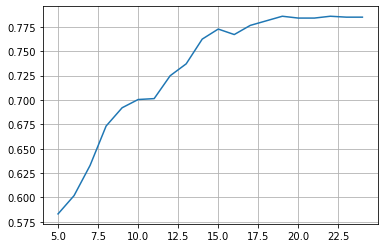

In [244]:
sns.lineplot(x=max_depth_series, y=accuracy_score_series)
plt.grid()
plt.show()

We can observe that a max_depth parameter above 19 does not further increase the accuracy of the model.

### Forum post by Andy Liaw, who maintains the randomForest package in R:

"For the most part, performance on training set is meaningless. (That's the case for most algorithms, but especially so for RF.) In the default (and recommended) setting, the trees are grown to the maximum size, which means that quite likely there's only one data point in most terminal nodes, and the prediction at the terminal nodes are determined by the majority class in the node, or the lone data point. Suppose that is the case all the time; i.e., in all trees all terminal nodes have only one data point. A particular data point would be "in-bag" in about 64% of the trees in the forest, and every one of those trees has the correct prediction for that data point. Even if all the trees where that data points are out-of-bag gave the wrong prediction, by majority vote of all trees, you still get the right answer in the end. Thus basically the perfect prediction on train set for RF is "by design"."

In [246]:
model = RandomForestClassifier(criterion='gini', bootstrap=False, max_depth=19, max_features='auto', min_samples_leaf=1, min_samples_split=2, n_estimators=110)

In [247]:
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=19, n_estimators=110)

In [250]:
# What is an accuracy on the test sample?
y_pred = model.predict(X_test)
accuracy_score(y_test,y_pred)

0.7765258215962442

We would like to see the confusion matrix, which may contain valuable tips for the construction of our investment strategy. Namely, do we want to include both long and short positions, or only long?

In [270]:
y_pred[y_pred==1].shape

(611,)

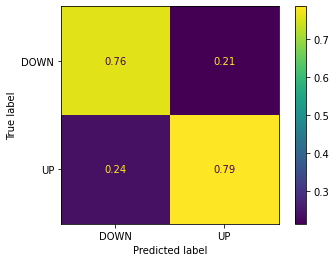

In [272]:
# Add confusion matrix
cm = confusion_matrix(y_test, y_pred,normalize='pred')
cmd = ConfusionMatrixDisplay(cm, display_labels=['DOWN','UP'])
cmd.plot()
plt.show()

In [ ]:
# Add variable importance

In [253]:
pickle.dump(model, open('model.sav', 'wb'))

# Backtesting

In [3]:
model = pickle.load(open('model.sav', 'rb'))

In [4]:
silver_price = yf.Ticker("SI=F").history(period='max')['Close']

In [153]:
data = pd.concat((data, silver_price), axis=1, join='inner')

In [154]:
data.tail()

,Silver_10,Gold_10,Silver_30,Gold_30,Silver_100,Gold_100,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,STOCHk_14_3_3,STOCHd_14_3_3,Target,Close
Date,,,,,,,,,,,,,,
2022-04-05,-1.434601,0.114545,0.892596,0.881383,-0.964995,4.075560,45.765999,0.012309,-0.157632,0.169940,19.278785,29.691669,1.0,24.528000
2022-04-06,-2.840684,-0.939789,-0.407251,0.481881,-3.343744,2.962649,45.080108,-0.028794,-0.158988,0.130193,15.633557,21.916861,1.0,24.455000
2022-04-07,-4.505791,-1.417207,0.190387,0.451928,-2.410827,3.528027,48.260228,-0.038492,-0.134949,0.096456,18.538042,17.816795,0.0,24.733000
2022-04-08,-3.031839,-0.624428,3.425430,2.920751,-1.147091,4.045871,49.239449,-0.038792,-0.108198,0.069407,24.210561,19.460720,0.0,24.819000
2022-04-11,-0.786463,0.242322,2.532739,2.363906,0.136307,4.893185,51.082768,-0.025900,-0.076245,0.050345,34.405501,25.718035,0.0,24.978001


In [155]:
# Buy and hold return on dataset
(data['Close'][-1] - data['Close'][0]) / data['Close'][0]

4.2200629963192355

In [156]:
years_delta = (data.index[-1] - data.index[0]).days / 365.2425
years_delta

21.20782767613298

In [157]:
CAGR_bah = ((data['Close'][-1] / data['Close'][0]) ** (1/years_delta) - 1)
CAGR_bah

0.0810359448508351

In [158]:
data['Prediction'] = model.predict(data.drop(['Target', 'Close'],axis=1))


In [159]:
series=data['Prediction']==data['Target']
series.value_counts()

True     5087
False     237
dtype: int64

In [163]:
accuracy_score(data['Target'], data['Prediction'], normalize=True)

0.9554845980465815

In [197]:
X_train['Prediction'] = model.predict(X_train)

In [198]:
accuracy_score(y_train,X_train['Prediction'])

1.0